In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from pyteomics.auxiliary import fdr, qvalues
from rdkit import Chem

In [2]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=2.5)

In [3]:
def inchi_to_smiles(inchi):
    try:
        mol = Chem.rdinchi.InchiToMol(inchi)[0]
    except ValueError:
        mol = None
    return Chem.MolToSmiles(mol, True) if mol is not None else None

In [4]:
def plot_cosine_vs_balance_fdr(scores_df, x_labels, y_labels):
    fig, ax = plt.subplots(figsize=(9, 6))
    
    sns.heatmap(scores_df, square=False, cbar_kws={'label': 'FDR (%)'},
                xticklabels=x_labels, yticklabels=y_labels,
                cmap=sns.cm.rocket_r, ax=ax)
    
    ax.invert_yaxis()
    
    ax.xaxis.set_tick_params(rotation=0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.xaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_major_locator(mticker.AutoLocator())

    ax.set_xlabel('Cosine score')
    ax.set_ylabel('Balance score (%)')
    
    return fig, ax

In [5]:
data_dir = '../data/Biswa'
filename = 'MOLECULAR-LIBRARYSEARCH-GC-5e38ef43-view_all_annotations_DB-main.tsv'

In [6]:
compounds_spiked = pd.read_csv(os.path.join(data_dir, 'compounds_spiked.csv'))
smiles_spiked = set(compounds_spiked['SMILES'])

In [7]:
spiked_categories_str = ('fatty acid esters', 'alkanes')

In [8]:
spiked_categories_inchikey = set()
with open(os.path.join(data_dir, 'classifications_all.tsv'), 'r') as f_in:
    for line in f_in:
        inchikey, *category = line.strip().split('\t')
        category = set([cat.strip().lower() for cat in category])
        if any(spiked_cat in category for spiked_cat in spiked_categories_str):
            spiked_categories_inchikey.add(inchikey)

In [9]:
compounds = (pd.read_csv(os.path.join(data_dir, filename), sep='\t',
                         usecols=['#Scan#', 'INCHI', 'MQScore',
                                  'Balance_score(percentage)'],
                         skipinitialspace=True)
             .dropna())

compounds['SMILES'] = compounds['INCHI'].apply(inchi_to_smiles)
compounds['is_spiked'] = compounds['SMILES'].isin(smiles_spiked)
compounds['InchiKey'] = compounds['INCHI'].apply(Chem.inchi.InchiToInchiKey)
compounds['is_spiked_category'] = compounds['InchiKey'].isin(spiked_categories_inchikey)
compounds = compounds.dropna()

In [10]:
scans_spiked_category = (compounds.sort_values(['#Scan#', 'MQScore'],
                                               ascending=[True, False])
                         .groupby('#Scan#').head(10)
                         .groupby('#Scan#')['is_spiked_category'].agg(any))
scans_spiked_category = scans_spiked_category[scans_spiked_category]
compounds = compounds[compounds['#Scan#'].isin(scans_spiked_category.index)]

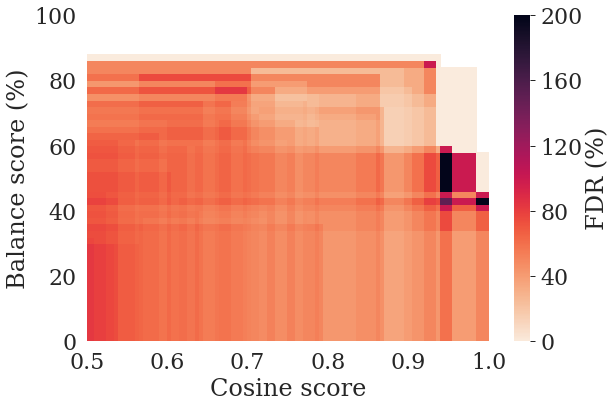

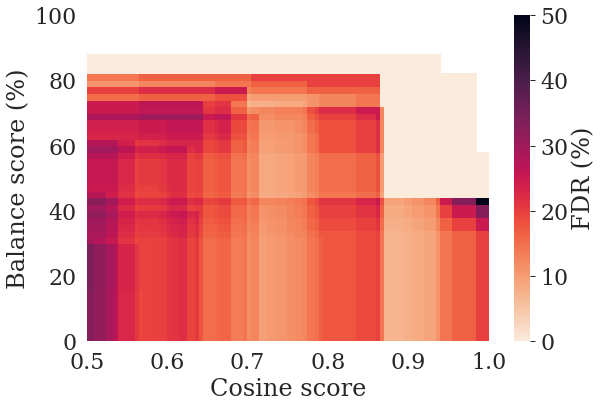

In [11]:
cosine_thresholds = np.arange(0.51, 1.01, 0.01)
balance_thresholds = np.arange(1, 101, 1)

for top in (1, 10):
    # Get the top N identifications per scan.
    compounds_top = (compounds.sort_values(['#Scan#', 'MQScore'],
                                           ascending=[True, False])
                     .groupby('#Scan#').head(top))
    # Get the top-ranked correct id within the top N identifications per scan.
    compounds_top = (compounds_top.sort_values(
        ['#Scan#', 'is_spiked', 'MQScore'], ascending=[True, False, False])
                     .groupby('#Scan#').head(1))
    # Relate cosine and balance score to FDR.
    fdr_map = np.full((len(cosine_thresholds), len(balance_thresholds)), np.nan)
    for i, cosine_threshold in enumerate(cosine_thresholds):
        for j, balance_threshold in enumerate(balance_thresholds):
            compounds_thresholded = compounds_top[
                (compounds_top['MQScore'] >= cosine_threshold) &
                (compounds_top['Balance_score(percentage)'] >= balance_threshold)]
            if len(compounds_thresholded) > 0:
                try:
                    fdr_map[i, j] = fdr(
                        is_decoy=~compounds_thresholded['is_spiked_category'])
                except ZeroDivisionError:
                    fdr_map[i, j] = 0
    
    # Cosine vs balance FDR heatmap.
    plot_cosine_vs_balance_fdr(
        fdr_map * 100, [f'{c:0.1f}' for c in np.arange(0.5, 1.05, 0.1)],
        np.arange(0, 101, 20))

    plt.savefig(f'fdr_map_{top}.svg', dpi=300)
    plt.show()
    plt.close()
    
#     # Q-value plot.
#     qs = [q for _, _, q in qvalues(
#         compounds_top, key='MQScore', reverse=True,
#         is_decoy=lambda x: not x['is_spiked_category'])]
#     fig, ax = plt.subplots(figsize=(9, 6))

#     ax.plot(qs, range(len(qs)))

#     ax.set_xlabel('FDR')
#     ax.set_ylabel('Number of identifications')

#     ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

#     sns.despine()

#     plt.show()
#     plt.close()